# Information From WHO
##### - Coronavirus disease (COVID-19) is an infectious disease caused by a new virus. The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. <br><br> - You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. <br><br> - Coronavirus disease spreads primarily through contact with an infected person when they cough or sneeze. It also spreads when a person touches a surface or object that has the virus on it, then touches their eyes, nose, or mouth.

### Initialization 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
py.offline.init_notebook_mode(connected=True)

Dataset obtained from kaggle: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv

In [2]:
df = pd.read_csv('covid_19_clean_complete.csv')

In [4]:
px.set_mapbox_access_token(token)

### Spread of Corona Virus over time

In [34]:
fig = px.scatter_mapbox(df, lat="Lat", lon="Long", color='Confirmed',size="Deaths",animation_frame="Date",color_continuous_scale=px.colors.sequential.Viridis,size_max=60, zoom=0)
fig.show()

<img src="Results/1_Map.gif" width="750" align="center">

## Mortality Rate in Each Countries 

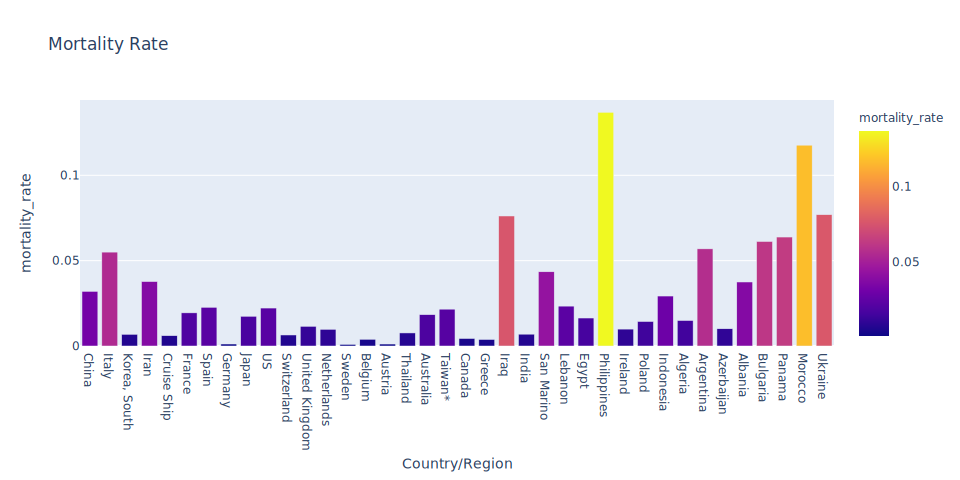

In [18]:
temp = df.groupby(['Country/Region'])['Confirmed','Deaths'].sum().reset_index().sort_values(['Confirmed'], ascending=[ False])
temp = temp[temp.Confirmed>=10]
temp['mortality_rate'] = temp.apply(lambda x: x['Deaths']/x['Confirmed'],axis=1)
fig = px.bar(temp[temp.mortality_rate!=0], x="Country/Region", y="mortality_rate", color='mortality_rate', title='Mortality Rate', height=600)
fig.show('svg',width=960, height=480)

 Dataset obtained from kaggle: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#COVID19_open_line_list.csv

In [20]:
df2 = pd.read_csv('COVID19_open_line_list.csv')

In [21]:
df2 = df2.dropna(subset=['age'])
def FiltAge(age):
    try:
        if len(age)==5:
            return np.random.randint(float(age[:2]),float(age[-2:]))
        elif len(age)==3:
            return np.random.randint(float(age[0]),float(age[2]))
        else:
            return int(age)
    except:
        return 0
df2['age'] = df2.apply(lambda x: FiltAge(x['age']),axis=1)        

## Number of Cases in Each Age Group

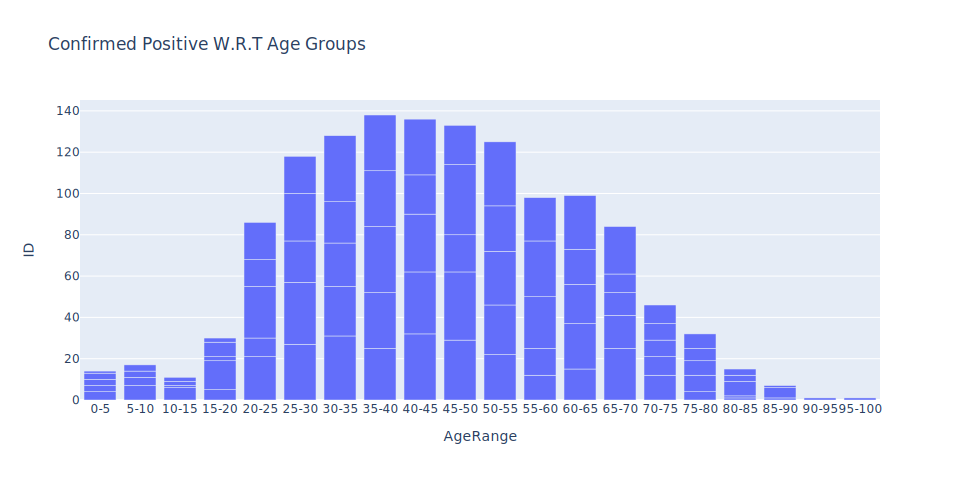

In [22]:
temp = df2.groupby(['age'])['ID'].count().reset_index().sort_values(['ID'], ascending=[ False])
temp['AgeRange'] = pd.cut(temp['age'], [5*x for x in range(0,21) ],labels=[str(5*x)+'-'+str(5*(x+1)) for x in range(0,20) ])
fig = px.bar(temp.sort_values('AgeRange'), x="AgeRange", y="ID",title='Confirmed Positive W.R.T Age Groups',height=600)
fig.show('svg',width=960, height=480)

## Symptoms Extracted From Dataset an it's Frequency

In [23]:
tempList = df2.symptoms.tolist()

In [24]:
symptoms = {'fever':0}
discarded = []
for ele in tempList:
    try:
        if ele != 'nan':
            tmpele = ele.split(',')
            for symp in tmpele:
                if 'fever' in symp.strip().lower():                    
                    symptoms['fever'] += 1
                elif symp.strip().lower() in symptoms.keys():                    
                    symptoms[symp.strip().lower()] += 1
                else:
                    symptoms[symp.strip().lower()] = 1 
    except:
        discarded.append(ele)      

In [25]:
SymptomsDf = pd.DataFrame.from_dict(symptoms,orient='index',columns=['Count'])
SymptomsDf = SymptomsDf[SymptomsDf.Count>=2].sort_values('Count',ascending=False)

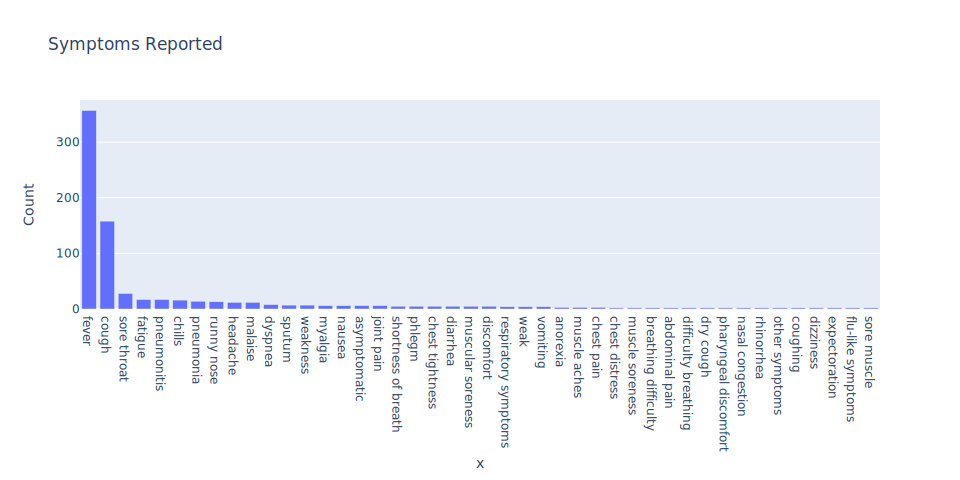

In [26]:
fig = px.bar(SymptomsDf, x=SymptomsDf.index, y="Count",title='Symptoms Reported',height=600)
fig.show('svg',width=960, height=480)

# Extracting all the Genome Files From NCBI Website

```python 

#Importing aa the required libraries
import ftplib
from io import BytesIO
import shutil

#Virus Dataset From Kaggle
virusgenome = pd.read_csv('genome-information/viruses.csv')
virusgenome['Virus_Id'] = virusgenome.index
virusgenome['Virus_Id'] = virusgenome.apply(lambda x: 'VID_'+str(x['Virus_Id']),axis=1)

#Function to find specific file in list
def find_genome_file(x):
    if 'genomic.fna' in x and 'cds' not in x:
        return x
    
#Function to Download all the genomes into fna files
def create_fna_file(x_GenBank,x_Virus_ID):
    try:
        import gzip
        '''Connect to FTP site'''
        ftp = ftplib.FTP('ftp.ncbi.nlm.nih.gov')
        ftp.login()
        ftp.cwd(x_GenBank.split('.gov/')[1])
        '''List of Files to be downloaded'''
        fileLink = list(filter(find_genome_file,ftp.nlst()))[0]
        '''Unzipping the File on the go and storing it as fna'''
        flo = BytesIO()
        ftp.retrbinary('RETR '+fileLink, flo.write)
        flo.seek(0)
        with open('gnomefna/'+x_Virus_ID+'.fna', 'wb') as fout, gzip.GzipFile(fileobj = flo) as gzip:
            shutil.copyfileobj(gzip, fout)
        return 'done'
    except:
        return 'not_done'
virusgenome['Download Status'] = virusgenome.apply(lambda x: create_fna_file(x['GenBank FTP'],x['Virus_Id']),axis=1)
virusgenome = virusgenome[['#Organism Name','Organism Groups','Virus_Id']]
```

# Importing BIO Python For Analysis of Genome Sequences

In [14]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

Some useful information from: https://microbe.net/simple-guides/fact-sheet-dna-rna-protein/
#### 1.  DNA is the genetic material of all cellular organisms.
Deoxyribonucleic acid (DNA) is the material substance of inheritance. All cellular organisms use DNA to encode and store their genetic information.  DNA is a chemical compound that resembles a long chain, with the links in the chain made up of individual chemical units called nucleotides.  The nucleotides themselves have three components: a sugar (deoxyribose), phosphate, and a nucleobase. The bases come in four chemical forms known as adenine, cytosine, guanine, and thymine, which are frequently simply abbreviated as A, C, G and T.  The order, or “sequence”, of bases encodes the information in DNA.
#### 2.  RNA ”carries” information
DNA holds information, but it generally does not actively apply that information. DNA does not make things. To extract the information and get it to the location of cellular machinery that can carry out its instructions (usually the blueprints for a protein, as we will see below) the DNA code is “transcribed” into a corresponding sequence in a “carrier” molecule called ribonucleic acid, or RNA.  The portions of DNA that are transcribed into RNA are called “genes”.
#### 3.  RNA molecules made in a cell are used in a variety of ways.
For our purposes here, there are three key types of RNA: messenger RNA, ribosomal RNA, and transfer RNA.  Messenger RNA (mRNA) carries the instructions for making proteins. Like DNA, proteins are polymers: long chains assembled from prefab molecular units, which, in the case of proteins, are amino acids. A large molecular machine* called the ribosome translates the mRNA code and assembles the proteins. Ribosomes read the message in mRNA in three letter “words” called codons, which translate to specific amino acids, or an instruction to stop making the protein. Each possible three letter arrangement of A,C,U,G (e.g., AAA, AAU, GGC, etc) is a specific instruction, and the correspondence of these instructions and the amino acids is known as the “genetic code.”

In [15]:
# Extracting Required Bio Information like https://www.kaggle.com/abishpius/covid-19-genome-proteins-analysis-with-biopython/
def Extract_Bio_Information(fname):
    try:
        
        #Parse DNA sequence
        DNAseq = next(SeqIO.parse('gnomefna/'+fname+'.fna', "fasta"))
        
        #DNA sequence Id
        Sequence_Id = DNAseq.id
        
        DNA = DNAseq.seq
        
        #Obtain mRNA Sequence
        mRNA = DNA.transcribe()
        
        #Obtain Amino_Acid Sequence from mRNA
        Amino_Acid = mRNA.translate()

        Amino_Acid_len, mRNA_len = len(Amino_Acid),len(mRNA)
        
        Proteins = Amino_Acid.split('*')
        
        #Extracting important information
        MW = []
        aromaticity =[]
        AA_Freq = []
        IsoElectric = []
        protiens_chains = []

        for j in Proteins[:]:
            if len(str(j))>0:
                protiens_chains.append(str(j))
                a = ProteinAnalysis(str(j))
                MW.append(a.molecular_weight())
                aromaticity.append(a.aromaticity())
                AA_Freq.append(a.count_amino_acids())
                IsoElectric.append(a.isoelectric_point())
        return Sequence_Id, mRNA_len,Amino_Acid_len,protiens_chains,MW,aromaticity,AA_Freq,IsoElectric
    except:
        return None,None,None,None,None,None,None,None
 
#Creating Dataset with all the Bio information
#new_col = ['DNA Sequence ID','Len of mRNA', 'Len of Amino Acid','Protiens','Molecular Weight','Aromaticity','Amino Acid Freq','IsoElectric Point']
#virusgenome[new_col] = virusgenome.apply(lambda x: Extract_Bio_Information(x['Virus_Id']),axis=1,result_type="expand")
#virusgenome.to_csv('Virus Genome Details.csv')

### Loading Saved Virus Dataset with all The Bio Information

In [16]:
virusgenome = pd.read_csv('Virus Genome Details.csv').drop('Unnamed: 0',axis=1)
virusgenome = virusgenome.dropna()
virusgenome.head()

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
0,Hamiltonella virus APSE1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_0,AF157835.1,36524.0,12174.0,"['LFSIVKRIFSNTRYIDNFFNSWHCETYRRMVGVN', 'KQMNNI...","[4214.786300000001, 8714.134499999993, 5231.98...","[0.20588235294117646, 0.09210526315789473, 0.1...","[{'A': 0, 'C': 1, 'D': 1, 'E': 1, 'F': 4, 'G':...","[9.77789306640625, 10.18292236328125, 6.008483..."
1,Chalara elegans RNA Virus 1,Viruses;dsRNA viruses;Totiviridae,VID_1,AY561500.1,5310.0,1770.0,['RKTSDEQNVPQLLPSLFFWVAHLHPGACFRRHLILTELGKSGPR...,"[8691.967699999994, 840.9274, 1412.54600000000...","[0.07692307692307693, 0.0, 0.07692307692307693...","[{'A': 6, 'C': 3, 'D': 2, 'E': 3, 'F': 3, 'G':...","[10.04962158203125, 9.69854736328125, 5.918151..."
2,Vibrio phage martha 12B12,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_2,HQ316581.1,33277.0,11092.0,"['IHCSATRNLSTRVWKFEH', 'CSNI', 'TLQLLDRIGWVPAH...","[2185.4673000000003, 435.4957, 2047.3167000000...","[0.1111111111111111, 0.0, 0.05555555555555555,...","[{'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 1, 'G':...","[9.50482177734375, 5.51812744140625, 6.4174194..."
3,Sclerotinia sclerotiorum partitivirus S,Viruses;dsRNA viruses;Partitiviridae,VID_3,GQ280377.1,1874.0,624.0,"['RLIILVHFLSSTKIKSKSS', 'PHRSFKTNNACP', 'PTIPF...","[2157.598, 1371.5240000000001, 1115.3184999999...","[0.05263157894736842, 0.08333333333333333, 0.1...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 1, 'G':...","[11.26385498046875, 9.56573486328125, 3.799987..."
4,Human papillomavirus 116,"Viruses;dsDNA viruses, no RNA stage;Papillomav...",VID_4,FJ804072.1,7184.0,2394.0,['MENPFPNDLRSYCNYFGICLFDLRLQCIFCKSILDIVDLAKFHK...,"[16636.29539999999, 417.41760000000005, 333.29...","[0.12765957446808512, 0.0, 0.0, 0.0, 0.1428571...","[{'A': 8, 'C': 14, 'D': 9, 'E': 6, 'F': 7, 'G'...","[8.37200927734375, 6.00213623046875, 5.2400512..."


#### Idea: Taking Amino Acid Sequences of all the virus for solving a classical NLP problem by creating a tf-idf matrix with cosine similarity. The closest N virus to the given virus is obtained. This might help to device a cure by understanding the cluster to which it belongs. 
##### Importing Tf-Idf implemented by Sklearn

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
def create_protiens_list(list_Protiens, tokens=0): 
    protiens = []
    for ele in list_Protiens:
        p = ele.split(',')[1:-1]
        p = [x[2:-1] for x in p]
        if not tokens:
            protiens.append(" ".join(p))
        else:
            protiens.append(p)
    return protiens

In [19]:
tf = TfidfVectorizer(norm='l2')
tfidf_matrix = tf.fit_transform(create_protiens_list(virusgenome['Protiens']))

In [20]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [21]:
def Get_N_Similar_Virus_tf(df,cosine_matrix,column='Virus_Id',value='VID_0',N=5,existing=1):
    if existing:
        idx = df.index[df[column]==value][0]
        All_scores = list(enumerate(cosine_matrix[idx]))
        Nearest_scores = sorted(All_scores, key=lambda x: x[1], reverse=True)
        DataFrameIndices = [i[0] for i in Nearest_scores]
        return df.iloc[DataFrameIndices[0:N]]
    else:
        All_scores = list(enumerate(cosine_matrix))
        Nearest_scores = sorted(All_scores, key=lambda x: x[1], reverse=True)
        DataFrameIndices = [i[0] for i in Nearest_scores]
        return df.iloc[DataFrameIndices[0:N]]
        

In [22]:
Get_N_Similar_Virus_tf(virusgenome,cosine_similarities,'Virus_Id','VID_128',3)

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
121,Primula malacoides virus China/Mar2007,Viruses;dsRNA viruses;Partitiviridae,VID_128,EU195326.1,2390.0,796.0,['DFFKPAPRLKNLEFTFVYDNQALSKPLLLYPTPTSQHAIQRCS'...,"[4996.696500000001, 1006.115, 1453.55640000000...","[0.13953488372093023, 0.0, 0.2727272727272727,...","[{'A': 3, 'C': 1, 'D': 2, 'E': 1, 'F': 4, 'G':...","[9.04583740234375, 12.00006103515625, 5.399475..."
838,Raphanus sativus cryptic virus 3,Viruses;dsRNA viruses;Partitiviridae,VID_882,FJ461349.1,1609.0,536.0,"['RIFPETHNRGTKT', 'QLRSQDFGRENHFITASLHHEKIAQPF...","[1556.7244999999998, 4664.211299999998, 2331.5...","[0.07692307692307693, 0.10256410256410256, 0.0...","[{'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G':...","[10.83502197265625, 10.66754150390625, 11.5675..."
2082,Chrysochromulina ericina virus,"Viruses;dsDNA viruses, no RNA stage;Phycodnavi...",VID_2176,KT820662.1,473558.0,157852.0,"['TLH', 'ISLLILKTSHLKLDDDGPTYQTKHNFFGIFKGGTPLT...","[369.4161, 6536.570499999998, 379.450600000000...","[0.0, 0.14035087719298245, 0.3333333333333333,...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[6.40155029296875, 8.29205322265625, 5.5249633..."


In [23]:
Get_N_Similar_Virus_tf(virusgenome,cosine_similarities,'#Organism Name','Bordetella virus BPP1',4)

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
302,Bordetella virus BPP1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_317,AY029185.2,42493.0,14164.0,"['WGG', 'WDSNPNYRGLQGNCGDFCL', 'FCRVLRVPLPRHPP...","[318.32779999999997, 2159.3170999999998, 8814....","[0.3333333333333333, 0.15789473684210525, 0.07...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52496337890625, 4.20782470703125, 12.155212..."
304,Bordetella phage BMP-1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_319,AY526908.1,42663.0,14221.0,"['WGG', 'WDSNPNYRGLQGNCGDFCL', 'FCRVLRVPLPRHPP...","[318.32779999999997, 2159.3170999999998, 8814....","[0.3333333333333333, 0.15789473684210525, 0.07...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52496337890625, 4.20782470703125, 12.155212..."
305,Bordetella phage BIP-1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_320,AY526909.1,42638.0,14212.0,"['WGG', 'WDSNPNYRGLQGNCGDFCL', 'FCRVLRVPLPRHPP...","[318.32779999999997, 2159.3170999999998, 8814....","[0.3333333333333333, 0.15789473684210525, 0.07...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52496337890625, 4.20782470703125, 12.155212..."
235,Etapapillomavirus 1,"Viruses;dsDNA viruses, no RNA stage;Papillomav...",VID_246,AY057109.1,7729.0,2576.0,['MRNRLPIGAQGPPGGQPSNNPSENNFNPEDWDILLDTDSSSGSE...,"[25039.565999999984, 418.4867, 2512.1319000000...","[0.06751054852320676, 0.3333333333333333, 0.0,...","[{'A': 17, 'C': 5, 'D': 18, 'E': 24, 'F': 11, ...","[3.71270751953125, 5.52496337890625, 12.016540..."


### Let's Extract Corona Virus Bio Information

In [24]:
Sequence_Id, mRNA_len,Amino_Acid_len,protiens_chains,MW,aromaticity,AA_Freq,IsoElectric = Extract_Bio_Information('Corona Virus')

In [25]:
new_col = ['DNA Sequence ID','Len of mRNA', 'Len of Amino Acid','Protiens','Molecular Weight','Aromaticity','Amino Acid Freq','IsoElectric Point']
pd.DataFrame([[Sequence_Id, mRNA_len,Amino_Acid_len,protiens_chains,MW,aromaticity,AA_Freq,IsoElectric]],columns=new_col)

,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
0,MN908947.3,29903,9967,"[IKGLYLPR, QTNQLSISCRSVL, TNFKICVAVTRLHA, CTHA...","[959.1858, 1448.6445, 1572.8727000000001, 529....","[0.125, 0.0, 0.07142857142857142, 0.0, 0.14285...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[9.99432373046875, 8.24969482421875, 9.4990844..."


### TOP 5 Similar Virus W.R.T COVID-19

In [26]:
test_matrix = tf.transform([' '.join(protiens_chains)])
cosine_matrix = cosine_similarity(test_matrix,tfidf_matrix)
Get_N_Similar_Virus_tf(virusgenome,cosine_matrix[0],existing=0)

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
1650,Bacillus virus G,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_1714,JN638751.1,497513.0,165837.0,['MFELSKIQSDTKALQNNLGKMKHQNKIGGVDLGDYIFNKLITKM...,"[63458.00510000017, 232.2768, 1148.391, 372.45...","[0.09285714285714286, 0.0, 0.4444444444444444,...","[{'A': 29, 'C': 7, 'D': 36, 'E': 33, 'F': 29, ...","[8.26470947265625, 5.18499755859375, 5.5243530..."
4183,Prochlorococcus phage P-SSM2,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_4342,GU071092.1,252407.0,84135.0,['MEPNKELEQAIANKFLTPVKFSMEIEKIVLEEGVNYIDAIVQYC...,"[9843.412699999993, 4382.330499999999, 1315.72...","[0.06976744186046512, 0.17142857142857143, 0.0...","[{'A': 6, 'C': 1, 'D': 3, 'E': 10, 'F': 3, 'G'...","[5.45367431640625, 10.02923583984375, 3.799865..."
943,Prochlorococcus phage P-SSM2,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_992,AY939844.2,252401.0,84133.0,['METIRIAGAQIPINDHDIDFNKKEILKAIDWAKENEVDELLTPE...,"[35940.41569999998, 146.1876, 1396.68250000000...","[0.09433962264150944, 0.0, 0.0, 0.0, 0.0, 0.42...","[{'A': 16, 'C': 8, 'D': 21, 'E': 22, 'F': 13, ...","[5.50091552734375, 8.75006103515625, 9.6121215..."
2071,Campylobacter virus CPt10,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_2164,FN667789.1,175720.0,58573.0,"['NY', 'NVSSLALNFKF', 'YII', 'S', 'KDL', 'C', ...","[295.2911, 1239.4191, 407.50370000000004, 105....","[0.5, 0.18181818181818182, 0.3333333333333333,...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52435302734375, 8.75006103515625, 5.5243530..."
1852,Staphylococcus phage MCE-2014,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_1931,KJ888149.1,141907.0,47302.0,"['SVLYNFFIEYL', 'HCIQIHLLHVVI', 'LNF', 'LIRFVF...","[1407.607, 1424.7553, 392.4493, 1994.488600000...","[0.36363636363636365, 0.0, 0.3333333333333333,...","[{'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 2, 'G':...","[3.99871826171875, 7.01177978515625, 5.5249633..."


### Finding similarity by creating a word2vec model and calculating WMD distance between them

In [27]:
import gensim 

In [28]:
tokenized_protien_list = create_protiens_list(virusgenome['Protiens'])

In [29]:
# Create CBOW model 
model1 = gensim.models.Word2Vec(tokenized_protien_list, size = 100)

In [30]:
def Get_N_Similar_Virus_word2vec(df,model,protien_lists,virus_protien_list =None,column='Virus_Id',value='VID_0',N=5,existing=1):
    if existing:
        idx = df.index[df[column]==value][0]
        virus_protien_list = tokenized_protien_list[idx]         
    similarity = []
    for i in range(len(tokenized_protien_list)):
        similarity.append(model1.wmdistance(tokenized_protien_list[i],virus_protien_list))
    All_scores = list(enumerate(similarity))
    Nearest_scores = sorted(All_scores, key=lambda x: x[1], reverse=False)
    DataFrameIndices = [i[0] for i in Nearest_scores]
    return df.iloc[DataFrameIndices[0:N]]

In [31]:
Get_N_Similar_Virus_word2vec(virusgenome,model1,tokenized_protien_list,value='VID_128')

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
121,Primula malacoides virus China/Mar2007,Viruses;dsRNA viruses;Partitiviridae,VID_128,EU195326.1,2390.0,796.0,['DFFKPAPRLKNLEFTFVYDNQALSKPLLLYPTPTSQHAIQRCS'...,"[4996.696500000001, 1006.115, 1453.55640000000...","[0.13953488372093023, 0.0, 0.2727272727272727,...","[{'A': 3, 'C': 1, 'D': 2, 'E': 1, 'F': 4, 'G':...","[9.04583740234375, 12.00006103515625, 5.399475..."
1346,Red clover cryptic virus 2,Viruses;dsRNA viruses;Partitiviridae,VID_1406,JX971978.1,2430.0,810.0,"['RFI', 'SGPRPNI', 'NSHSSTNFPTK', 'LLTLLFLLTSN...","[434.5324, 739.8201999999999, 1219.2608, 5276....","[0.3333333333333333, 0.0, 0.09090909090909091,...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 1, 'G':...","[9.75006103515625, 9.46514892578125, 8.7572631..."
1347,Hop trefoil cryptic virus 2,Viruses;dsRNA viruses;Partitiviridae,VID_1407,JX971980.1,2431.0,810.0,"['RFFISGPRL', 'YLEFTFV', 'FFPFTNNC', 'PLLF', '...","[1092.2932999999998, 918.0425999999999, 989.10...","[0.2222222222222222, 0.42857142857142855, 0.37...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 2, 'G':...","[12.00006103515625, 3.99969482421875, 5.518127..."
2601,Cannabis cryptic virus,Viruses;dsRNA viruses;Partitiviridae,VID_2712,KX709964.1,2397.0,799.0,"['RFFISAPRLI', 'LRINIRLSYQAFTKPLL', 'LFTTTSHHA...","[1219.4775, 2046.4577000000004, 2043.329799999...","[0.2, 0.11764705882352941, 0.05555555555555555...","[{'A': 1, 'C': 0, 'D': 0, 'E': 0, 'F': 2, 'G':...","[12.00006103515625, 11.00042724609375, 8.09075..."
783,Ceratocystis polonica partitivirus,Viruses;dsRNA viruses;Partitiviridae,VID_825,AY247204.1,2315.0,771.0,"['RHSIVP', 'RSN', 'NKSP', 'QYAFFQC', 'PHLPNPHR...","[707.8213999999999, 375.38089999999994, 444.48...","[0.0, 0.0, 0.0, 0.42857142857142855, 0.0, 0.30...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[9.75653076171875, 9.75006103515625, 8.7500610..."


In [32]:
Get_N_Similar_Virus_word2vec(virusgenome,model1,tokenized_protien_list,column='#Organism Name',value='Bordetella virus BPP1')

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
302,Bordetella virus BPP1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_317,AY029185.2,42493.0,14164.0,"['WGG', 'WDSNPNYRGLQGNCGDFCL', 'FCRVLRVPLPRHPP...","[318.32779999999997, 2159.3170999999998, 8814....","[0.3333333333333333, 0.15789473684210525, 0.07...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52496337890625, 4.20782470703125, 12.155212..."
304,Bordetella phage BMP-1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_319,AY526908.1,42663.0,14221.0,"['WGG', 'WDSNPNYRGLQGNCGDFCL', 'FCRVLRVPLPRHPP...","[318.32779999999997, 2159.3170999999998, 8814....","[0.3333333333333333, 0.15789473684210525, 0.07...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52496337890625, 4.20782470703125, 12.155212..."
305,Bordetella phage BIP-1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",VID_320,AY526909.1,42638.0,14212.0,"['WGG', 'WDSNPNYRGLQGNCGDFCL', 'FCRVLRVPLPRHPP...","[318.32779999999997, 2159.3170999999998, 8814....","[0.3333333333333333, 0.15789473684210525, 0.07...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[5.52496337890625, 4.20782470703125, 12.155212..."
773,Azospirillum phage Cd,"Viruses;dsDNA viruses, no RNA stage;Siphoviridae",VID_813,CU468217.1,62337.0,20779.0,"['LPRLLPSPRRL', 'YRMASIQPESSMRAASSPLTAVSWAAVSA...","[1317.6257, 29632.582399999963, 3097.848200000...","[0.0, 0.0808080808080808, 0.07407407407407407,...","[{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G':...","[12.30108642578125, 10.38592529296875, 9.49969..."
1301,Pseudomonas phage JBD30,"Viruses;dsDNA viruses, no RNA stage;Siphoviridae",VID_1360,JX434032.1,36947.0,12315.0,"['LWGGDCFDTCQKRDG', 'ARAPITLGLQPERRRAGVWKISIRI...","[1700.8496, 4712.493, 3133.6684999999993, 3489...","[0.13333333333333333, 0.024390243902439025, 0....","[{'A': 0, 'C': 2, 'D': 3, 'E': 0, 'F': 1, 'G':...","[4.42889404296875, 11.78558349609375, 9.499450..."


In [33]:
Get_N_Similar_Virus_word2vec(virusgenome,model1,tokenized_protien_list,existing=0,virus_protien_list=' '.join(protiens_chains))

,#Organism Name,Organism Groups,Virus_Id,DNA Sequence ID,Len of mRNA,Len of Amino Acid,Protiens,Molecular Weight,Aromaticity,Amino Acid Freq,IsoElectric Point
4603,Synechococcus phage ACG-2014b,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_4793,KJ019132.1,172261.0,57420.0,['MSFASLKKASSGGDTFAKLTREIDKLNQPAAGSSADERFWKPEM...,"[35507.0286000001, 710.7789, 6895.291899999996...","[0.12025316455696203, 0.0, 0.05, 0.06666666666...","[{'A': 32, 'C': 0, 'D': 26, 'E': 27, 'F': 19, ...","[4.87677001953125, 6.74114990234375, 8.7595825..."
4409,Synechococcus phage ACG-2014b,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_4580,KJ019043.1,172688.0,57562.0,['MSFASLKKASSGGDTFAKLTREIDKLNQPAAGSSADERFWKPEM...,"[35507.0286000001, 710.7789, 6895.291899999996...","[0.12025316455696203, 0.0, 0.05, 0.06666666666...","[{'A': 32, 'C': 0, 'D': 26, 'E': 27, 'F': 19, ...","[4.87677001953125, 6.74114990234375, 8.7595825..."
4582,Synechococcus phage ACG-2014b,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_4766,KJ019109.1,172688.0,57562.0,['MSFASLKKASSGGDTFAKLTREIDKLNQPAAGSSADERFWKPEM...,"[35507.0286000001, 710.7789, 6895.291899999996...","[0.12025316455696203, 0.0, 0.05, 0.06666666666...","[{'A': 32, 'C': 0, 'D': 26, 'E': 27, 'F': 19, ...","[4.87677001953125, 6.74114990234375, 8.7595825..."
2663,Cyanophage S-RIM32,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_2775,KU594606.1,194437.0,64812.0,['MSFADLKRKSQANFDFLQKELTKSSTEGGADERLWKPELDASGN...,"[32543.691700000054, 591.6584, 1185.3288, 917....","[0.11683848797250859, 0.0, 0.09090909090909091...","[{'A': 31, 'C': 3, 'D': 23, 'E': 26, 'F': 16, ...","[4.77825927734375, 11.00018310546875, 6.740173..."
4564,Synechococcus phage ACG-2014b,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",VID_4748,KJ019108.1,172688.0,57562.0,['MSFASLKKASSGGDTFAKLTREIDKLNQPAAGSSADERFWKPEM...,"[35507.0286000001, 710.7789, 6895.291899999996...","[0.12025316455696203, 0.0, 0.05, 0.06666666666...","[{'A': 32, 'C': 0, 'D': 26, 'E': 27, 'F': 19, ...","[4.87677001953125, 6.74114990234375, 8.7595825..."
